In [1]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D,GlobalMaxPooling1D, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
from sklearn.utils import shuffle
dataset = pd.read_csv('train.csv', encoding='ISO-8859-1', header= None)
dataset = dataset.rename(index=str, columns={ 0: "review", 1: "aspect_category", 2: "sentiment"})
dataset.review = dataset.review.str.lower()
dataset = shuffle(dataset)
dataset.head(5)

,review,aspect_category,sentiment
522,back to back lessons can get tiring,learning,Neutral
506,make the right technical decisions and grow th...,learning,Neutral
267,this should at a high level to reward good peo...,leadership,Positive
169,"constant change due to explosive growth, not a...",environment,Neutral
641,training courses are average at best and then ...,learning,Neutral


In [11]:
import spacy
nlp = spacy.load('en')

dataset.review = dataset.review.str.lower()

aspect_terms = []
for review in nlp.pipe(dataset.review):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
dataset['aspect_terms'] = aspect_terms
dataset.head(10)

,review,aspect_category,sentiment,aspect_terms
522,back to back lessons can get tiring,learning,Neutral,lessons
506,make the right technical decisions and grow th...,learning,Neutral,decisions careers
267,this should at a high level to reward good peo...,leadership,Positive,level managers
169,"constant change due to explosive growth, not a...",environment,Neutral,change growth thing
641,training courses are average at best and then ...,learning,Neutral,courses ground
616,you can learn and grow very fast.,learning,Positive,
47,you get to be part of one of the most innovati...,environment,Positive,part companies planet
396,managers support upward and lateral mobility a...,leadership,Positive,managers employees
649,no coaching,learning,Negative,coaching
608,lots of opportunities at amazon.,learning,Positive,lots opportunities amazon


In [13]:
max_fatures = 6000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['aspect_terms'].values)
X = tokenizer.texts_to_sequences(dataset['aspect_terms'].values)
X = pad_sequences(X)

In [14]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(max_fatures, embedding_dim, input_length = X.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 6, 128)            768000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 128)            0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total para

In [15]:
Y = pd.get_dummies(dataset['aspect_category']).values
#print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(527, 6) (527, 3)
(132, 6) (132, 3)


In [16]:
batch_size = 32
sentiment_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs = 10, batch_size=batch_size, verbose = 2)

Train on 527 samples, validate on 132 samples
Epoch 1/10
 - 1s - loss: 1.0953 - acc: 0.3567 - val_loss: 1.0909 - val_acc: 0.4242
Epoch 2/10
 - 0s - loss: 1.0725 - acc: 0.4497 - val_loss: 1.0627 - val_acc: 0.5682
Epoch 3/10
 - 0s - loss: 1.0043 - acc: 0.5693 - val_loss: 1.0163 - val_acc: 0.5758
Epoch 4/10
 - 0s - loss: 0.8653 - acc: 0.6831 - val_loss: 0.9078 - val_acc: 0.6212
Epoch 5/10
 - 0s - loss: 0.6634 - acc: 0.7799 - val_loss: 0.8126 - val_acc: 0.6364
Epoch 6/10
 - 0s - loss: 0.5125 - acc: 0.8197 - val_loss: 0.8443 - val_acc: 0.6212
Epoch 7/10
 - 0s - loss: 0.4024 - acc: 0.8691 - val_loss: 0.8775 - val_acc: 0.6288
Epoch 8/10
 - 0s - loss: 0.3637 - acc: 0.8653 - val_loss: 0.9159 - val_acc: 0.6364
Epoch 9/10
 - 0s - loss: 0.3303 - acc: 0.8824 - val_loss: 0.9356 - val_acc: 0.6288
Epoch 10/10
 - 0s - loss: 0.3100 - acc: 0.8805 - val_loss: 0.9732 - val_acc: 0.6212


<Figure size 432x288 with 0 Axes>

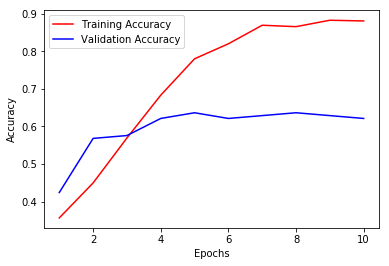

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = sentiment_model.history['acc']
val_acc = sentiment_model.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color = 'red', label='Training acc')
plt.plot(epochs, val_acc, color = 'blue', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.figure()

In [18]:
import numpy as np 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


y_predict = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_predict ]

matrix = confusion_matrix(y_test_non_category, y_predict_non_category)
print(matrix)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_non_category, y_predict_non_category)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_non_category, y_predict_non_category,average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_non_category, y_predict_non_category,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_non_category, y_predict_non_category,average='macro')
print('F1 score: %f' % f1)

[[28  6  6]
 [16 34  4]
 [12  6 20]]
Accuracy: 0.621212
Precision: 0.635266
Recall: 0.618648
F1 score: 0.617190
